# Supervised Classification
This jupyter notebook contains the code and a report on the usage of different classification methods to predict categories on the UCI Machine Learning dataset "Teacher Assistant Evaluation".

The work contained within is created by: <br>
Sharon Ramírez   - A01379035 <br>
Andrea Gonzáles  - A01176527 <br>
Yareth Lafarge   - A00835326 <br>
Rafael Martínez  - A01274853 <br>

The Teacher Assistant Dataset contains 151 entries with 5 attributes each, categorizing an entry into one of three categories:<br>
1 - Low<br>
2 - Medium<br>
3 - High<br>



## Basic Imports and Dataset Loading
For this work, Pandas will be used for data handling, and numpy for most mathematical operations. Additional imports will be used depending on each classifier, but they will be explained in their own sections.

We load the dataset as a Pandas dataframe. The .data file does not contain headers, so we add our own to allow for easier visualization. Here is a short description of each attribute:
- English? - Whether the TA is a native english speaker. 1 = Yes. 2 = No.
- Instructor - A number identifying the instructor, it is a generic category.
- Course - A number identifying the course, it is a generic category.
- Summer? - Whether the course was taught as a summer or regular class. 1 = Yes. 2 = No.
- Class Size - A number corresponding to the size of the class.
- Quality - The score of the TA, divided into one of three. 1 = Low. 2 = Medium. 3 = High.

In [1]:
#Basic imports
import pandas as pd
import numpy as np

#Database import
teacher_dataset=pd.read_csv('tae.data',names=["English?","Instructor","Course","Summer?","Class Size","Quality"])
print(teacher_dataset)

     English?  Instructor  Course  Summer?  Class Size  Quality
0           1          23       3        1          19        3
1           2          15       3        1          17        3
2           1          23       3        2          49        3
3           1           5       2        2          33        3
4           2           7      11        2          55        3
..        ...         ...     ...      ...         ...      ...
146         2           3       2        2          26        1
147         2          10       3        2          12        1
148         1          18       7        2          48        1
149         2          22       1        2          51        1
150         2           2      10        2          27        1

[151 rows x 6 columns]


## Decision Trees
Decisions trees are based on dividing categories into a flowchart that allows one decision to lead to the other consecutively, until we eventually reach a conclusion. 

For this work, two things will be shown:
- A step-by-step construction of the first level of the decision tree using the full dataset for didactic purposes.
- A Scikit Learn trained model using an 80/20 split for training/testing.

### Manual Approach
Scikit Learn includes a module for generating and training a decision, but first we will explain step-by-step how the construction of such an algorith is made, in order to justify the use of this technique for classification.

### Entropy
For the optimal construction of a decision tree, it is important to know how much information is given by each attribute, as to decide the level at which each should be. 

To determine what the level of information gained is, we use the Shannon model. Note that usually for binary decision trees we would see a range of 0 to 1 for information gain (at most, we gain a bit of information corresponding to a binary decision), but this is trinary tree: We have three possible outcomes. As such, information gains can be greater than 1.

Determining the entropy of an attribute, that is, how 'disordered' it is and therefore how much information we can gain by ordering it, we use the following equation:

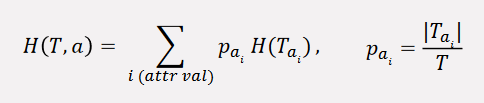

Where H(T,a) is the entropy for a particular attribute, a, for a certain number of counts, T. p is the 'probability', which is the observed amount of counts for each partition of an attribute (Ta) divided by the total number of counts. To calculate H(Ta) we use the sum of each Shannon information gain per partition:

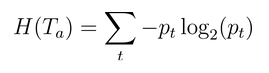

Each 't' is an entry for that partition.

We create a function that calculates the entropy for any attribute for a generic dataframe. It does the following:
- Groups the dataframe by that attribute
- Calculates the total number of entries
- Calculates the size of each partition for that attribute
- Calculates the information per partition
- Calculates the entropy per partition
- Sums the entropies and returns them

In [2]:
## INPUT: Dataframe, attribute and category as string
## OUTPUT: Entropy, as a number, and the dataframe with all the calculation data
def entropy(dataframe, attribute, category):
    dfaux = dataframe.groupby([attribute, category], as_index=False).size()
    df = dataframe.groupby([attribute], as_index=False).size()
    count = dfaux["size"].sum()
    
    # Get total size for each category
    df = df.rename(columns={"size":"total"})
    dfaux = pd.merge(dfaux, df, how="left", on=attribute)
    
    # Calculate information per row
    dfaux["info"]=-(dfaux["size"]/dfaux["total"])*np.log2(dfaux["size"]/dfaux["total"])
    
    # Calculate entropy
    dfaux = dfaux.groupby([attribute],as_index=False).sum()
    dfaux["entropy"] = dfaux["info"]*(dfaux["size"]/count)
    entropy = dfaux["entropy"].sum()
    
    return entropy, dfaux


In [3]:
[entropyE,t] = entropy(teacher_dataset,"English?","Quality")
[entropyI,t] = entropy(teacher_dataset,"Instructor","Quality")
[entropyC,t1] = entropy(teacher_dataset,"Course","Quality")
[entropyS,t] = entropy(teacher_dataset,"Summer?","Quality")
[entropyCS,t] = entropy(teacher_dataset,"Class Size","Quality")


## Print entropies:
print("Total Entropies per Attribute:")
print("==============================================")
print("Course in English? -- "+str(entropyE))
print("Instructor         -- "+str(entropyI))
print("Course             -- "+str(entropyC))
print("Summer Course?     -- "+str(entropyS))
print("Size of class      -- "+str(entropyCS))

Total Entropies per Attribute:
Course in English? -- 1.5288054271129314
Instructor         -- 1.180139907706205
Course             -- 1.150869239749956
Summer Course?     -- 1.5225056243291086
Size of class      -- 0.764631679828438


Now, to decide which attribute to put as root, we choose the highest information gain by substracting each entropy from the general entropy:

In [4]:
## General entropy
qualitas = teacher_dataset.groupby(["Quality"], as_index=False).size()
genEnt = -(qualitas.iloc[0,1]/151)*np.log2(qualitas.iloc[0,1]/151)-(qualitas.iloc[1,1]/151)*np.log2(qualitas.iloc[1,1]/151)-(qualitas.iloc[2,1]/151)*np.log2(qualitas.iloc[2,1]/151)

print("General Entropy:")
print(genEnt)
print("")

## Information Gain
print("Information Gain per Attribute:")
print("==========================================")
print("Course in English? -- "+str(genEnt-entropyE))
print("Instructor         -- "+str(genEnt-entropyI))
print("Course             -- "+str(genEnt-entropyC))
print("Summer Course?     -- "+str(genEnt-entropyS))
print("Size of class      -- "+str(genEnt-entropyCS))

General Entropy:
1.5845209168501235

Information Gain per Attribute:
Course in English? -- 0.05571548973719209
Instructor         -- 0.4043810091439186
Course             -- 0.4336516771001675
Summer Course?     -- 0.0620152925210149
Size of class      -- 0.8198892370216855


## Iterating to find next levels

Our root is **size of class**. This attribute has a lot of values that immediately determine the quality of the class. We will first determine the leaves, which is what attributes cause the tree to be immediately finalized -- we do this by checking where we have entropy 0:

In [5]:
## INPUT: A dataframe, the attribute's name, and a trinary category
def findLeaves(dataframe, attribute, category="Quality"):
    df = dataframe.groupby([attribute], as_index=False).count()
    df = df[attribute]
    leaves = []
    subtables = []
    for i in df:
        dfaux = teacher_dataset.query("`"+str(attribute)+"` == "+str(i))
        [x, t] = entropy(dfaux, attribute, category)
        if  x == 0:
            leaves.append(i)
        else:
            subtables.append(dfaux)
    return leaves, subtables

[leaves, subtables] = findLeaves(teacher_dataset, "Class Size")


Here is what is found after looking for leaves, and some of the resulting subtables.

In [6]:
print("Leaves:")
print(leaves)
print("A sampling of some subtables:")
print(subtables[0])
print(subtables[5])

Leaves:
[3, 5, 7, 9, 12, 16, 18, 22, 26, 28, 32, 33, 34, 35, 39, 43, 44, 45, 46, 48, 49, 51, 54, 55, 58, 66]
A sampling of some subtables:
     English?  Instructor  Course  Summer?  Class Size  Quality
16          2           7      11        2          10        2
18          2          13       3        1          10        2
55          2           7      11        2          10        2
57          2          13       3        1          10        2
106         2          23       3        2          10        2
144         2          19       4        2          10        1
     English?  Instructor  Course  Summer?  Class Size  Quality
1           2          15       3        1          17        3
40          2          15       3        1          17        3
79          1          13       3        1          17        3
89          2          14      22        2          17        3
121         2          13      14        2          17        3
132         2          14    

We now will continue to split it, using the next best attribute (by checking info gain) for each branch.

In [8]:
for i in range(0, len(subtables)):
    df = subtables[i]
    classSize = df.iloc[0,4]
    df = df.drop(columns=["Class Size"])
    [entropyE,t] = entropy(teacher_dataset,"English?","Quality")
    [entropyI,t] = entropy(teacher_dataset,"Instructor","Quality")
    [entropyC,t1] = entropy(teacher_dataset,"Course","Quality")
    [entropyS,t] = entropy(teacher_dataset,"Summer?","Quality")
    qualitas = df.groupby(["Quality"], as_index=False).size()
    size = qualitas.shape
    size = size[0]
    genEnt = 0
    try:
        genEnt = -(qualitas.iloc[0,1]/size)*np.log2(qualitas.iloc[0,1]/size)
    except IndexError:
        pass
    try:
        genEnt += -(qualitas.iloc[1,1]/size)*np.log2(qualitas.iloc[1,1]/size)
    except IndexError:
        pass
    try:
        genEnt += -(qualitas.iloc[2,1]/size)*np.log2(qualitas.iloc[2,1]/size)
    except IndexError:
        pass
    ordered = np.array([("English?", genEnt - entropyE),
                        ("Instructor",genEnt - entropyI),
                        ("Course",genEnt - entropyC),
                        ("Summer?",genEnt - entropyS)], dtype=[("x","S10"),("y", float)])
    ordered.sort(order="y")
    best = ordered[-1][0]
    best = best.decode("utf-8")
    
    print("For branch Class Size = "+str(classSize)+", the best category is "+str(best))
    if genEnt == 0:
        print("->Additionally, it's homogenous!")

For branch Class Size = 10, the best category is Course
For branch Class Size = 11, the best category is Course
For branch Class Size = 13, the best category is Course
->Additionally, it's homogenous!
For branch Class Size = 14, the best category is Course
For branch Class Size = 15, the best category is Course
For branch Class Size = 17, the best category is Course
For branch Class Size = 19, the best category is Course
For branch Class Size = 20, the best category is Course
For branch Class Size = 21, the best category is Course
For branch Class Size = 23, the best category is Course
For branch Class Size = 24, the best category is Course
For branch Class Size = 25, the best category is Course
For branch Class Size = 27, the best category is Course
For branch Class Size = 29, the best category is Course
For branch Class Size = 30, the best category is Course
->Additionally, it's homogenous!
For branch Class Size = 31, the best category is Course
For branch Class Size = 36, the best c

From here, we can continue checking each level iteratively. For this, we will use Scikit Learn's Decision Tree model using an 80/20 split of data for training and testing.

## Scikit Learn -- Training a decision tree
-- pon aqui yareth :)